In [32]:
import pandas as pd
import numpy as np

In [33]:
df = pd.read_pickle('data/SBAmodel.pickle')
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
display(df.head(1))
print(df.shape)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,region
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47,FIFTH THIRD BANK,OH,4,1997-02-28,1997,84,4,2,0,0,1,0,0,1,NaN,1999-02-28,60000.0,$0.00,1,0.0,60000.0,48000.0,Midwest


(897167, 28)


In [34]:
len(df.loc[df.Term == 0])

806

# pipeline

In [35]:
from sklearn.impute import SimpleImputer
from feature_engine.discretisation import ArbitraryDiscretiser
from sklearn.pipeline import FunctionTransformer, make_pipeline
from sklearn.model_selection import train_test_split
from feature_engine.creation import RelativeFeatures
import seaborn as sns

X = df.drop(columns=['MIS_Status'])
y = df.MIS_Status

#X.UrbanRural = X.NoEmp.astype(int)
X.region = X.region.astype('category')

#### Après analyse et tests on garde: #####
X = X[['Term', 'UrbanRural', 'FranchiseCode', 'LowDoc', 'GrAppv', 'RetainedJob', 'SBA_Appv', 'NoEmp', 'region']]
ohe_cols = ['UrbanRural', 'LowDoc', 'FranchiseCode', 'NoEmp', 'region']

X['Term'] = SimpleImputer(missing_values=0).fit_transform(X.loc[:, ['Term']])

def enterprise_discretizer(df):
    custom_bins = [0, 10, 20, float('inf')]
    df[['NoEmp']] = ArbitraryDiscretiser(binning_dict={'NoEmp': custom_bins}, return_object=True).fit_transform(df[['NoEmp']])
    
    return df

enterprise_discretizer_transformer = FunctionTransformer(enterprise_discretizer)
enterprise_discretizer_transformer.fit_transform(X)

#display(X.head())
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.05,
    stratify=y,
    random_state=42
)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 897167 entries, 0 to 899163
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Term           897167 non-null  float64 
 1   UrbanRural     897167 non-null  category
 2   FranchiseCode  897167 non-null  int64   
 3   LowDoc         897167 non-null  int64   
 4   GrAppv         897167 non-null  float64 
 5   RetainedJob    897167 non-null  int64   
 6   SBA_Appv       897167 non-null  float64 
 7   NoEmp          897167 non-null  object  
 8   region         897167 non-null  category
dtypes: category(2), float64(3), int64(3), object(1)
memory usage: 56.5+ MB


In [36]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from feature_engine.selection import DropConstantFeatures

set_config(transform_output = "pandas")

polynomial = PolynomialFeatures()
ohe = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')

def create_immo(x, column):
    x['immo'] = np.where(x[column] >= 240, 1, 0)
    return x
    
immo = FunctionTransformer(create_immo, kw_args={'column': 'Term'})
drop_constant = DropConstantFeatures(tol = 0.95)

transformers = ColumnTransformer(
    transformers = [
        ('ohe', ohe, ohe_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

scaler = StandardScaler()
estimator = XGBClassifier()

pipe = make_pipeline(
            transformers,
            immo,
            drop_constant,
            polynomial,
            scaler,
            #estimator
        )

X_train_transf = pipe.fit_transform(X_train, y_train)
X_test_transf = pipe.fit_transform(X_test, y_test)

display(X_train_transf.head(1))
print(X_train_transf.shape, X_train.shape)

,1,UrbanRural_0,UrbanRural_1,UrbanRural_2,LowDoc_1,FranchiseCode_1,NoEmp_0,NoEmp_1,NoEmp_2,region_Midwest,region_Northeast,region_Southeast,region_Southwest,region_West,Term,GrAppv,RetainedJob,SBA_Appv,immo,UrbanRural_0^2,UrbanRural_0 UrbanRural_1,UrbanRural_0 UrbanRural_2,UrbanRural_0 LowDoc_1,UrbanRural_0 FranchiseCode_1,UrbanRural_0 NoEmp_0,UrbanRural_0 NoEmp_1,UrbanRural_0 NoEmp_2,UrbanRural_0 region_Midwest,UrbanRural_0 region_Northeast,UrbanRural_0 region_Southeast,UrbanRural_0 region_Southwest,UrbanRural_0 region_West,UrbanRural_0 Term,UrbanRural_0 GrAppv,UrbanRural_0 RetainedJob,UrbanRural_0 SBA_Appv,UrbanRural_0 immo,UrbanRural_1^2,UrbanRural_1 UrbanRural_2,UrbanRural_1 LowDoc_1,UrbanRural_1 FranchiseCode_1,UrbanRural_1 NoEmp_0,UrbanRural_1 NoEmp_1,UrbanRural_1 NoEmp_2,UrbanRural_1 region_Midwest,UrbanRural_1 region_Northeast,UrbanRural_1 region_Southeast,UrbanRural_1 region_Southwest,UrbanRural_1 region_West,UrbanRural_1 Term,UrbanRural_1 GrAppv,UrbanRural_1 RetainedJob,UrbanRural_1 SBA_Appv,UrbanRural_1 immo,UrbanRural_2^2,UrbanRural_2 LowDoc_1,UrbanRural_2 FranchiseCode_1,UrbanRural_2 NoEmp_0,UrbanRural_2 NoEmp_1,UrbanRural_2 NoEmp_2,UrbanRural_2 region_Midwest,UrbanRural_2 region_Northeast,UrbanRural_2 region_Southeast,UrbanRural_2 region_Southwest,UrbanRural_2 region_West,UrbanRural_2 Term,UrbanRural_2 GrAppv,UrbanRural_2 RetainedJob,UrbanRural_2 SBA_Appv,UrbanRural_2 immo,LowDoc_1^2,LowDoc_1 FranchiseCode_1,LowDoc_1 NoEmp_0,LowDoc_1 NoEmp_1,LowDoc_1 NoEmp_2,LowDoc_1 region_Midwest,LowDoc_1 region_Northeast,LowDoc_1 region_Southeast,LowDoc_1 region_Southwest,LowDoc_1 region_West,LowDoc_1 Term,LowDoc_1 GrAppv,LowDoc_1 RetainedJob,LowDoc_1 SBA_Appv,LowDoc_1 immo,FranchiseCode_1^2,FranchiseCode_1 NoEmp_0,FranchiseCode_1 NoEmp_1,FranchiseCode_1 NoEmp_2,FranchiseCode_1 region_Midwest,FranchiseCode_1 region_Northeast,FranchiseCode_1 region_Southeast,FranchiseCode_1 region_Southwest,FranchiseCode_1 region_West,FranchiseCode_1 Term,FranchiseCode_1 GrAppv,FranchiseCode_1 RetainedJob,FranchiseCode_1 SBA_Appv,FranchiseCode_1 immo,NoEmp_0^2,NoEmp_0 NoEmp_1,NoEmp_0 NoEmp_2,NoEmp_0 region_Midwest,NoEmp_0 region_Northeast,NoEmp_0 region_Southeast,NoEmp_0 region_Southwest,NoEmp_0 region_West,NoEmp_0 Term,NoEmp_0 GrAppv,NoEmp_0 RetainedJob,NoEmp_0 SBA_Appv,NoEmp_0 immo,NoEmp_1^2,NoEmp_1 NoEmp_2,NoEmp_1 region_Midwest,NoEmp_1 region_Northeast,NoEmp_1 region_Southeast,NoEmp_1 region_Southwest,NoEmp_1 region_West,NoEmp_1 Term,NoEmp_1 GrAppv,NoEmp_1 RetainedJob,NoEmp_1 SBA_Appv,NoEmp_1 immo,NoEmp_2^2,NoEmp_2 region_Midwest,NoEmp_2 region_Northeast,NoEmp_2 region_Southeast,NoEmp_2 region_Southwest,NoEmp_2 region_West,NoEmp_2 Term,NoEmp_2 GrAppv,NoEmp_2 RetainedJob,NoEmp_2 SBA_Appv,NoEmp_2 immo,region_Midwest^2,region_Midwest region_Northeast,region_Midwest region_Southeast,region_Midwest region_Southwest,region_Midwest region_West,region_Midwest Term,region_Midwest GrAppv,region_Midwest RetainedJob,region_Midwest SBA_Appv,region_Midwest immo,region_Northeast^2,region_Northeast region_Southeast,region_Northeast region_Southwest,region_Northeast region_West,region_Northeast Term,region_Northeast GrAppv,region_Northeast RetainedJob,region_Northeast SBA_Appv,region_Northeast immo,region_Southeast^2,region_Southeast region_Southwest,region_Southeast region_West,region_Southeast Term,region_Southeast GrAppv,region_Southeast RetainedJob,region_Southeast SBA_Appv,region_Southeast immo,region_Southwest^2,region_Southwest region_West,region_Southwest Term,region_Southwest GrAppv,region_Southwest RetainedJob,region_Southwest SBA_Appv,region_Southwest immo,region_West^2,region_West Term,region_West GrAppv,region_West RetainedJob,region_West SBA_Appv,region_West immo,Term^2,Term GrAppv,Term RetainedJob,Term SBA_Appv,Term immo,GrAppv^2,GrAppv RetainedJob,GrAppv SBA_Appv,GrAppv immo,RetainedJob^2,RetainedJob SBA_Appv,RetainedJob immo,SBA_Appv^2,SBA_Appv immo,immo^2
603184,0.0,-0.74966,0.954704,-0.364094,-1.333937,0.549515,0.564717,-0.375679,-0.36597

(852308, 190) (852308, 9)


## Fit grid

In [37]:
estimator = XGBClassifier(
    # gamma= 0,
    # max_depth= 5,
    # min_child_weight= 3,
    # n_estimators= 400,
    # scale_pos_weight= 1,
    # colsample_bytree= 0.7,
    # subsample= 0.9,
)

grid = GridSearchCV(estimator, { 
    #'gamma': [0],       #np.arange(.1, 1, .1),
    #'max_depth': [5],   #np.arange(3, 8, 1, dtype=int),
    #'min_child_weight': range(1, 6, 2),
    #'n_estimators': np.arange(200, 500, 100, dtype=int),
    'subsample': np.arange(.6, 1, .1),
    'colsample_bytree': np.arange(.6, 1, .1),
    #'scale_pos_weight': [1],
    # 'xgbclassifier__objective': 'binary:logistic',
    # 'xgbclassifier__base_score': None,
    # 'xgbclassifier__booster': None,
    # 'xgbclassifier__callbacks': None,
    # 'xgbclassifier__colsample_bylevel': None,
    # 'xgbclassifier__colsample_bynode': None,
    # 'xgbclassifier__device': None,
    # 'xgbclassifier__early_stopping_rounds': None,
    # 'xgbclassifier__enable_categorical': False,
    # 'xgbclassifier__eval_metric': None,
    # 'xgbclassifier__feature_types': None,
    # 'xgbclassifier__grow_policy': None,
    # 'xgbclassifier__importance_type': None,
    # 'xgbclassifier__interaction_constraints': None,
    # 'xgbclassifier__learning_rate': None,
    # 'xgbclassifier__max_bin': None,
    # 'xgbclassifier__max_cat_threshold': None,
    # 'xgbclassifier__max_cat_to_onehot': None,
    # 'xgbclassifier__max_delta_step': None,
    # 'xgbclassifier__max_leaves': None,
    # 'xgbclassifier__missing': np.nan,
    # 'xgbclassifier__monotone_constraints': None,
    # 'xgbclassifier__multi_strategy': None,
    # 'xgbclassifier__n_jobs': [16],
    # 'xgbclassifier__num_parallel_tree': None,
    # 'xgbclassifier__random_state': None,
    # 'xgbclassifier__reg_alpha': None,
    # 'xgbclassifier__reg_lambda': None,
    # 'xgbclassifier__sampling_method': None,
    # 'xgbclassifier__tree_method': None,
    # 'xgbclassifier__validate_parameters': None,
    # 'xgbclassifier__verbosity': None
}, cv=5, scoring='f1_macro', n_jobs=-1)

#grid.fit(X_train_transf, y_train)

pipe = estimator.fit(X_train_transf, y_train)

In [38]:
# pipe = grid.best_estimator_

# grid.best_params_
X_train_transf.head(1)

,1,UrbanRural_0,UrbanRural_1,UrbanRural_2,LowDoc_1,FranchiseCode_1,NoEmp_0,NoEmp_1,NoEmp_2,region_Midwest,region_Northeast,region_Southeast,region_Southwest,region_West,Term,GrAppv,RetainedJob,SBA_Appv,immo,UrbanRural_0^2,UrbanRural_0 UrbanRural_1,UrbanRural_0 UrbanRural_2,UrbanRural_0 LowDoc_1,UrbanRural_0 FranchiseCode_1,UrbanRural_0 NoEmp_0,UrbanRural_0 NoEmp_1,UrbanRural_0 NoEmp_2,UrbanRural_0 region_Midwest,UrbanRural_0 region_Northeast,UrbanRural_0 region_Southeast,UrbanRural_0 region_Southwest,UrbanRural_0 region_West,UrbanRural_0 Term,UrbanRural_0 GrAppv,UrbanRural_0 RetainedJob,UrbanRural_0 SBA_Appv,UrbanRural_0 immo,UrbanRural_1^2,UrbanRural_1 UrbanRural_2,UrbanRural_1 LowDoc_1,UrbanRural_1 FranchiseCode_1,UrbanRural_1 NoEmp_0,UrbanRural_1 NoEmp_1,UrbanRural_1 NoEmp_2,UrbanRural_1 region_Midwest,UrbanRural_1 region_Northeast,UrbanRural_1 region_Southeast,UrbanRural_1 region_Southwest,UrbanRural_1 region_West,UrbanRural_1 Term,UrbanRural_1 GrAppv,UrbanRural_1 RetainedJob,UrbanRural_1 SBA_Appv,UrbanRural_1 immo,UrbanRural_2^2,UrbanRural_2 LowDoc_1,UrbanRural_2 FranchiseCode_1,UrbanRural_2 NoEmp_0,UrbanRural_2 NoEmp_1,UrbanRural_2 NoEmp_2,UrbanRural_2 region_Midwest,UrbanRural_2 region_Northeast,UrbanRural_2 region_Southeast,UrbanRural_2 region_Southwest,UrbanRural_2 region_West,UrbanRural_2 Term,UrbanRural_2 GrAppv,UrbanRural_2 RetainedJob,UrbanRural_2 SBA_Appv,UrbanRural_2 immo,LowDoc_1^2,LowDoc_1 FranchiseCode_1,LowDoc_1 NoEmp_0,LowDoc_1 NoEmp_1,LowDoc_1 NoEmp_2,LowDoc_1 region_Midwest,LowDoc_1 region_Northeast,LowDoc_1 region_Southeast,LowDoc_1 region_Southwest,LowDoc_1 region_West,LowDoc_1 Term,LowDoc_1 GrAppv,LowDoc_1 RetainedJob,LowDoc_1 SBA_Appv,LowDoc_1 immo,FranchiseCode_1^2,FranchiseCode_1 NoEmp_0,FranchiseCode_1 NoEmp_1,FranchiseCode_1 NoEmp_2,FranchiseCode_1 region_Midwest,FranchiseCode_1 region_Northeast,FranchiseCode_1 region_Southeast,FranchiseCode_1 region_Southwest,FranchiseCode_1 region_West,FranchiseCode_1 Term,FranchiseCode_1 GrAppv,FranchiseCode_1 RetainedJob,FranchiseCode_1 SBA_Appv,FranchiseCode_1 immo,NoEmp_0^2,NoEmp_0 NoEmp_1,NoEmp_0 NoEmp_2,NoEmp_0 region_Midwest,NoEmp_0 region_Northeast,NoEmp_0 region_Southeast,NoEmp_0 region_Southwest,NoEmp_0 region_West,NoEmp_0 Term,NoEmp_0 GrAppv,NoEmp_0 RetainedJob,NoEmp_0 SBA_Appv,NoEmp_0 immo,NoEmp_1^2,NoEmp_1 NoEmp_2,NoEmp_1 region_Midwest,NoEmp_1 region_Northeast,NoEmp_1 region_Southeast,NoEmp_1 region_Southwest,NoEmp_1 region_West,NoEmp_1 Term,NoEmp_1 GrAppv,NoEmp_1 RetainedJob,NoEmp_1 SBA_Appv,NoEmp_1 immo,NoEmp_2^2,NoEmp_2 region_Midwest,NoEmp_2 region_Northeast,NoEmp_2 region_Southeast,NoEmp_2 region_Southwest,NoEmp_2 region_West,NoEmp_2 Term,NoEmp_2 GrAppv,NoEmp_2 RetainedJob,NoEmp_2 SBA_Appv,NoEmp_2 immo,region_Midwest^2,region_Midwest region_Northeast,region_Midwest region_Southeast,region_Midwest region_Southwest,region_Midwest region_West,region_Midwest Term,region_Midwest GrAppv,region_Midwest RetainedJob,region_Midwest SBA_Appv,region_Midwest immo,region_Northeast^2,region_Northeast region_Southeast,region_Northeast region_Southwest,region_Northeast region_West,region_Northeast Term,region_Northeast GrAppv,region_Northeast RetainedJob,region_Northeast SBA_Appv,region_Northeast immo,region_Southeast^2,region_Southeast region_Southwest,region_Southeast region_West,region_Southeast Term,region_Southeast GrAppv,region_Southeast RetainedJob,region_Southeast SBA_Appv,region_Southeast immo,region_Southwest^2,region_Southwest region_West,region_Southwest Term,region_Southwest GrAppv,region_Southwest RetainedJob,region_Southwest SBA_Appv,region_Southwest immo,region_West^2,region_West Term,region_West GrAppv,region_West RetainedJob,region_West SBA_Appv,region_West immo,Term^2,Term GrAppv,Term RetainedJob,Term SBA_Appv,Term immo,GrAppv^2,GrAppv RetainedJob,GrAppv SBA_Appv,GrAppv immo,RetainedJob^2,RetainedJob SBA_Appv,RetainedJob immo,SBA_Appv^2,SBA_Appv immo,immo^2
603184,0.0,-0.74966,0.954704,-0.364094,-1.333937,0.549515,0.564717,-0.375679,-0.36597

# Feature importance + score

              precision    recall  f1-score   support

      test 0       0.80      0.78      0.79      7878
      test 1       0.95      0.96      0.96     36981

    accuracy                           0.93     44859
   macro avg       0.88      0.87      0.87     44859
weighted avg       0.93      0.93      0.93     44859

              precision    recall  f1-score   support

     train 0       0.85      0.80      0.83    149680
     train 1       0.96      0.97      0.96    702628

    accuracy                           0.94    852308
   macro avg       0.90      0.89      0.90    852308
weighted avg       0.94      0.94      0.94    852308



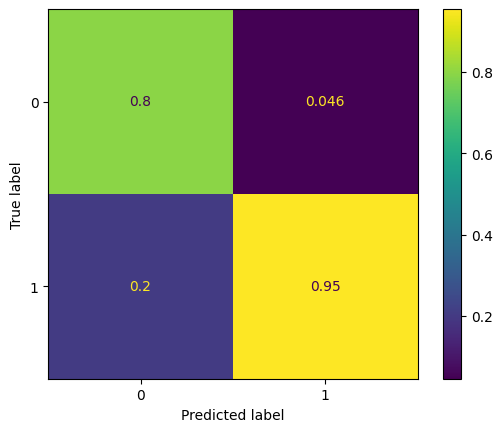

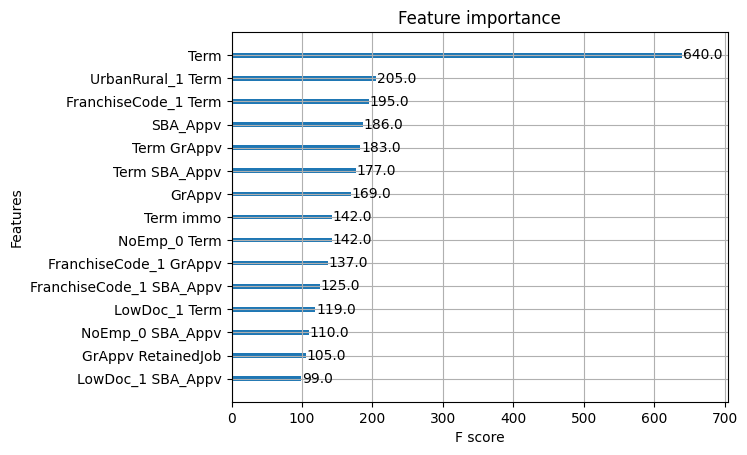

In [39]:
from utils import feature_importance
from matplotlib import pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = pipe.predict(X_test_transf)
print(classification_report(y_test, y_pred, target_names=['test 0', 'test 1']))

y_pred_train = pipe.predict(X_train_transf)
print(classification_report(y_train, y_pred_train, target_names=['train 0', 'train 1']))

cf_matrix = confusion_matrix(y_test, y_pred, normalize='pred')
ConfusionMatrixDisplay(cf_matrix).plot()

plot_importance(pipe, max_num_features=15, importance_type='weight')
plt.show()

In [52]:
from joblib import dump

model_path = 'models/model_grid.joblib'
dump(pipe, model_path) 

['models/model_grid.joblib']

## Load du modèle

In [8]:
from joblib import load
model_path = 'models/model_grid.joblib'

m = load(model_path)
pipe = m

## Sur train

## Sur test

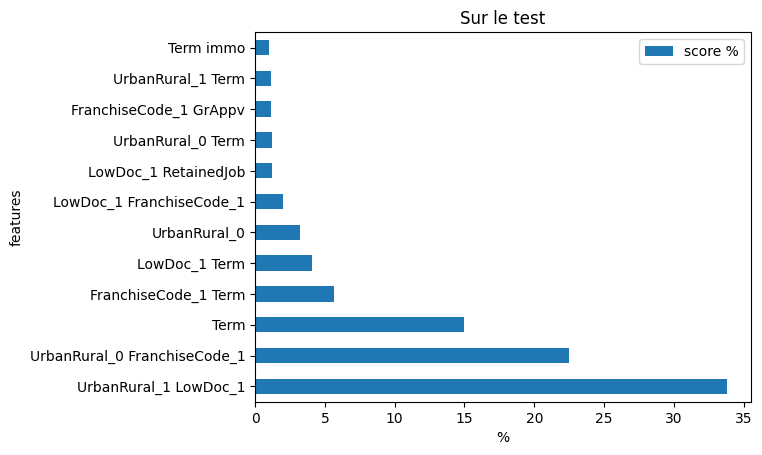

In [140]:
from matplotlib import pyplot as plt
f, X_test_transf = feature_importance(X_test, y_test, pipe)

f.loc[f['score %'] >= 1].plot.barh(y='score %', x='features')
plt.title('Sur le test')
plt.xlabel('%')
plt.legend()

# Score

In [15]:
from sklearn.metrics import classification_report

y_pred = pipe.predict(X_test_transf)
print(classification_report(y_test, y_pred, target_names=['test 0', 'test 1']))

y_pred_train = pipe.predict(X_train_transf)
print(classification_report(y_train, y_pred_train, target_names=['train 0', 'train 1']))

              precision    recall  f1-score   support

      test 0       0.76      0.78      0.77      7878
      test 1       0.95      0.95      0.95     36981

    accuracy                           0.92     44859
   macro avg       0.86      0.86      0.86     44859
weighted avg       0.92      0.92      0.92     44859

              precision    recall  f1-score   support

     train 0       0.84      0.79      0.81    149680
     train 1       0.96      0.97      0.96    702628

    accuracy                           0.94    852308
   macro avg       0.90      0.88      0.89    852308
weighted avg       0.93      0.94      0.93    852308



# Matrice de confusion

## Sur test

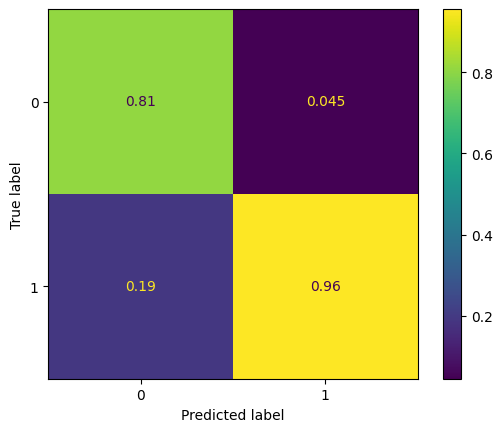

In [132]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred, normalize='pred')
ConfusionMatrixDisplay(cf_matrix).plot()

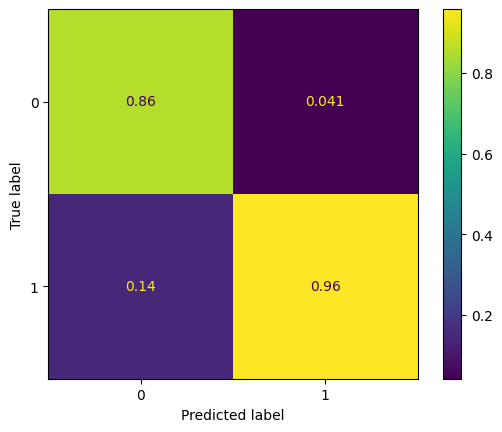

In [133]:
cf_matrix = confusion_matrix(y_train, y_pred_train, normalize='pred')
ConfusionMatrixDisplay(cf_matrix).plot()